In [9]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import copy
from scipy import stats
import scipy.misc
import matplotlib.pyplot as plt

# Main paper

## Figure 1


In [5]:
import os
import sys

path_common=os.path.dirname(os.path.abspath(''))+"/Common/";
sys.path.append(path_common) #Adds common path to import the python files

In [7]:
from DatasetFuncs import load_unfolded_df,show_partition_nanopores #We load the unfolded dataframe
df_unfolded=load_unfolded_df()

Text(0.5, 1.0, 'Index 3980 - Barcode 111')

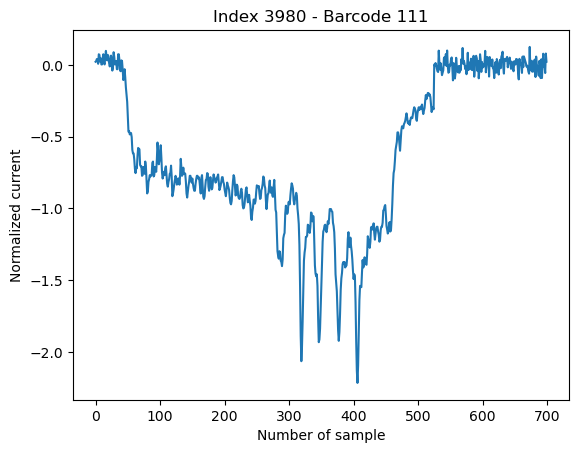

In [10]:
id_sample=3980;
trace_to_use_example=df_unfolded.iloc[id_sample]["trace"];
barcode=df_unfolded.iloc[id_sample]["barcode"];
plt.figure()
plt.plot(trace_to_use_example)
plt.xlabel("Number of sample")
plt.ylabel("Normalized current")
plt.title("Index "+str(id_sample) + " - Barcode "+barcode)

In [11]:
repetitions=np.tile(trace_to_use_example, (200, 1)); ##Repeat many times for running with the augmentation
np.shape(repetitions)

(200, 700)

In [12]:
from DataAugmentator import DataAugmentator ##Using the augmentation from  the validation part because is easier (no cupy required and we get the noise values)
da=DataAugmentator();
out,noise=da.brow_aug(repetitions,ret_noise=True);

Instructions for updating:
Use tf.identity instead.


Here we have augmented many times and we plot the outputs to pick an illustrative example for the paper:

100


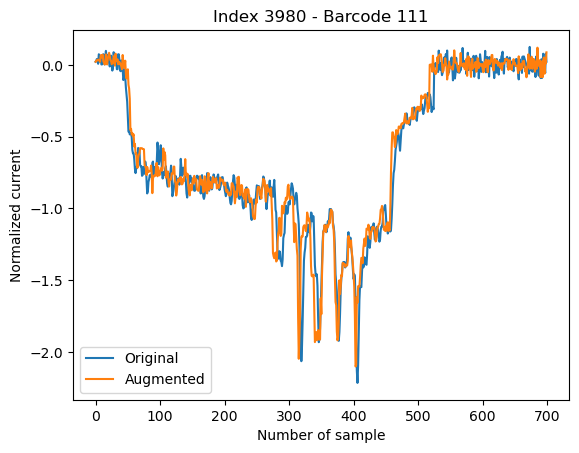

101


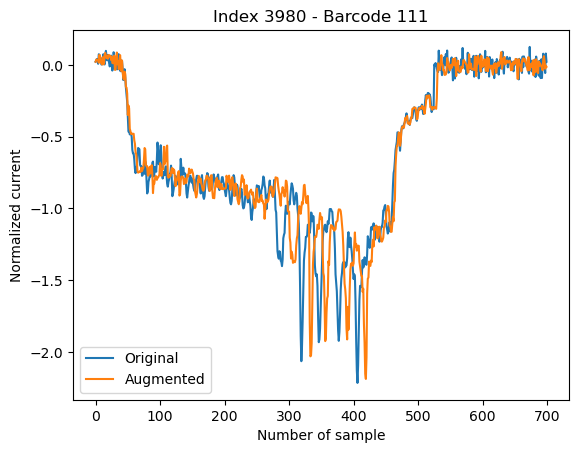

102


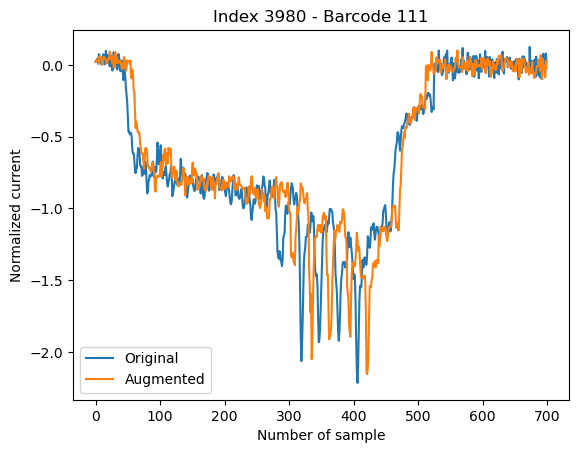

103


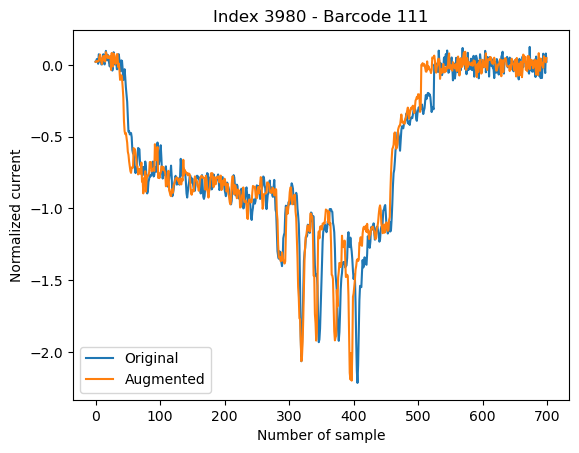

104


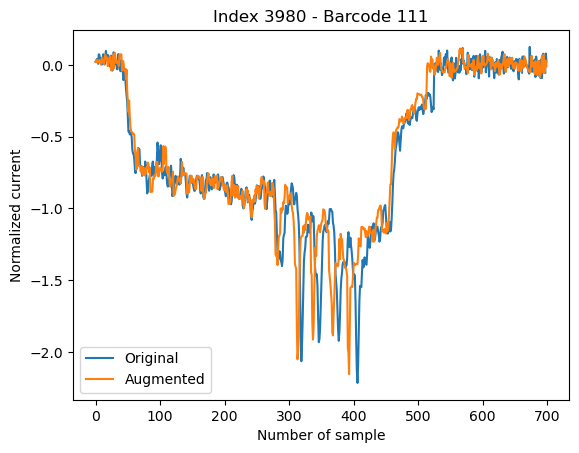

105


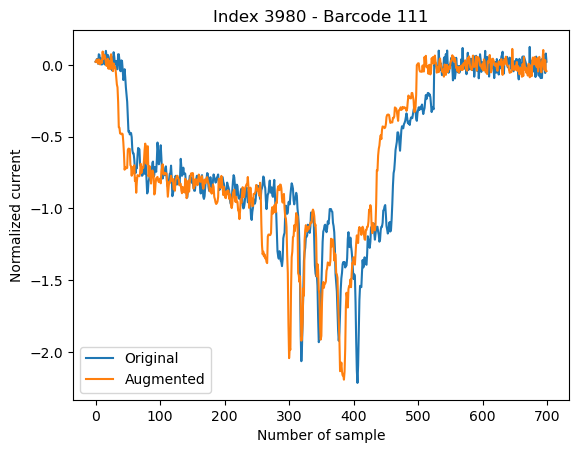

106


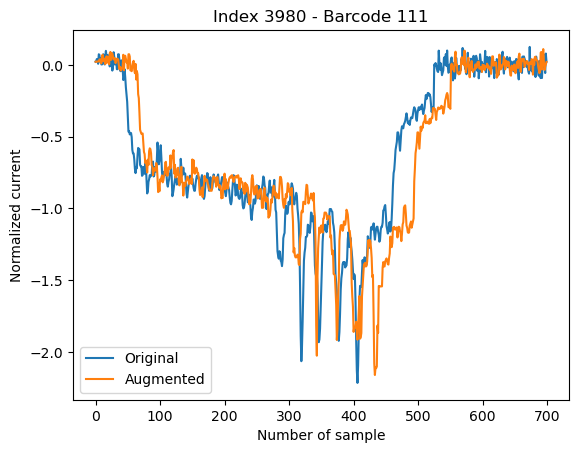

107


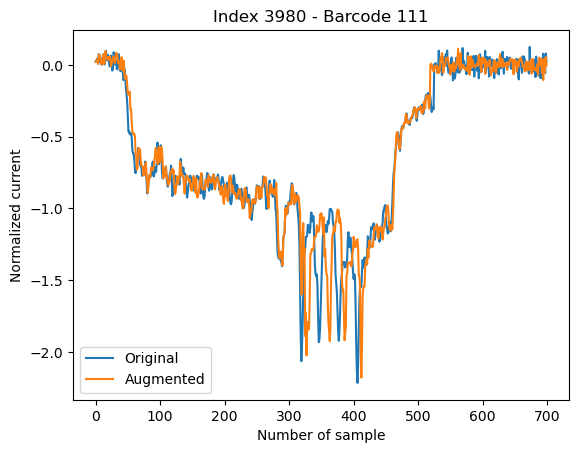

108


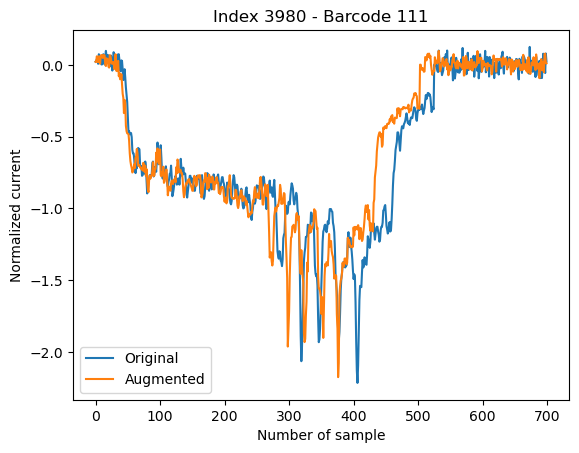

109


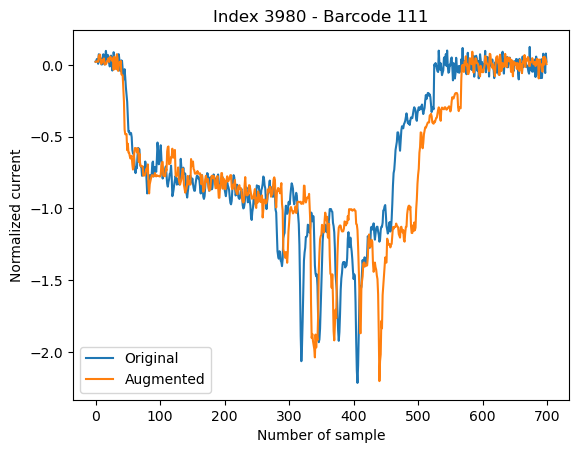

110


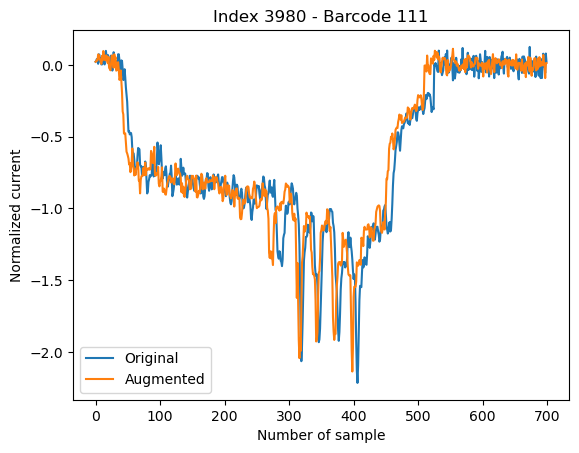

111


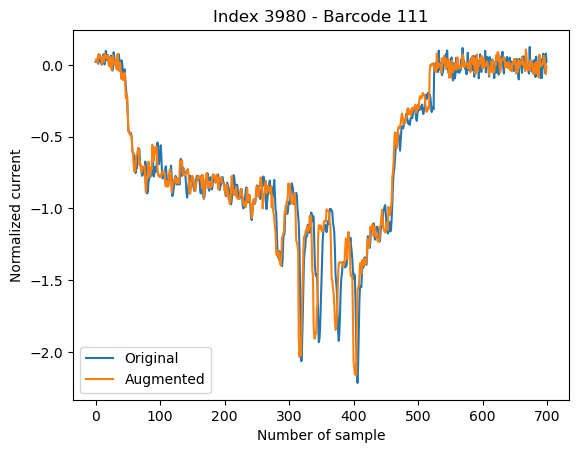

112


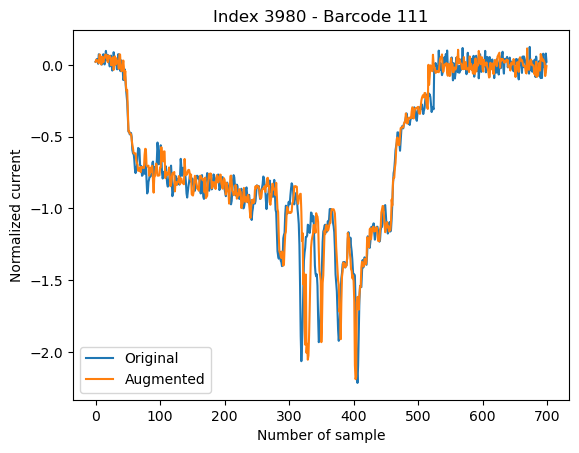

113


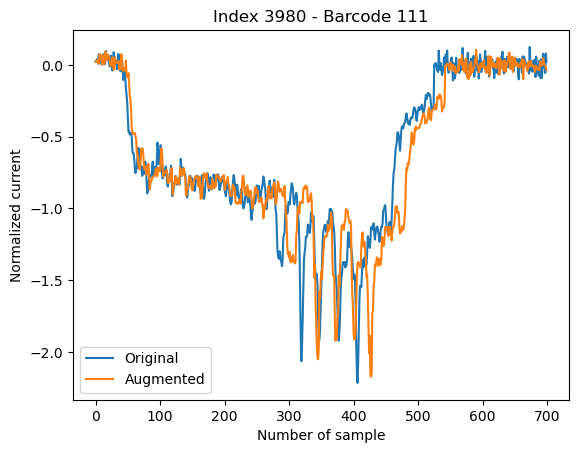

114


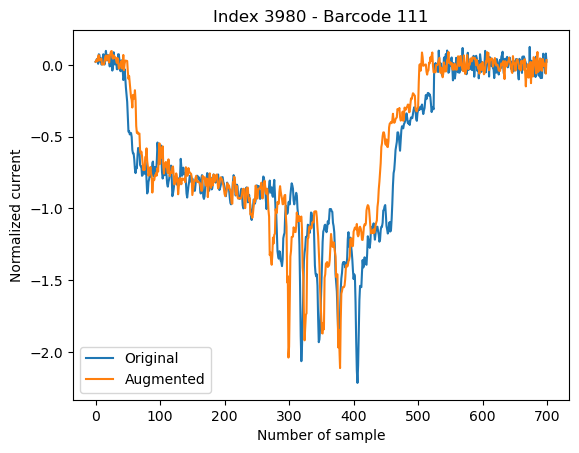

115


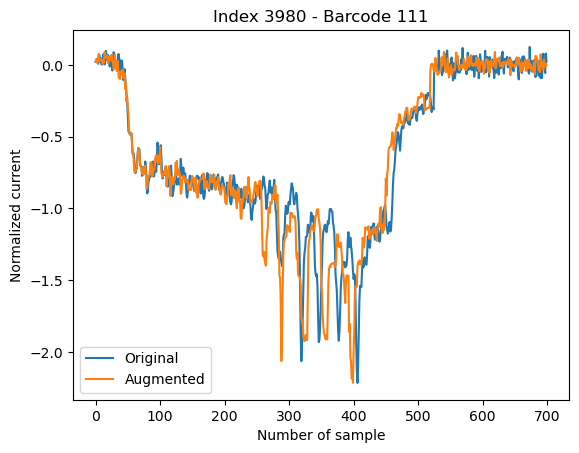

116


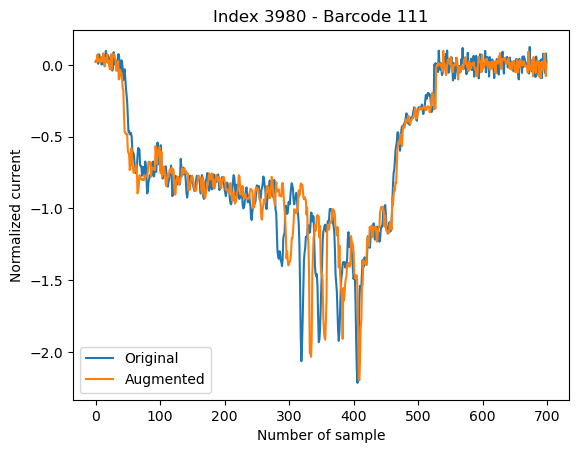

117


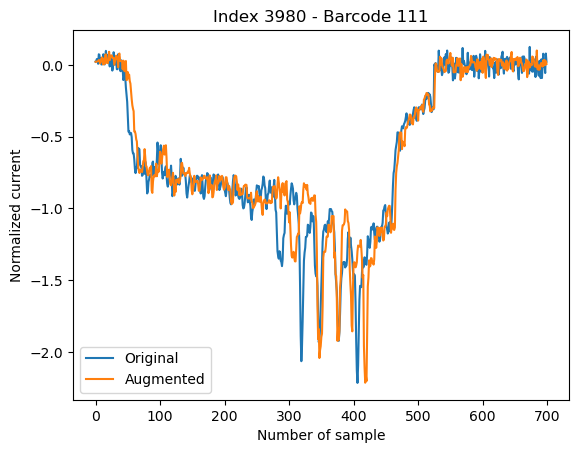

118


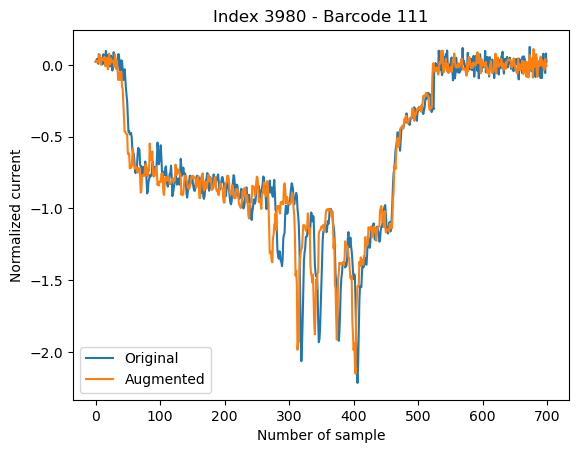

119


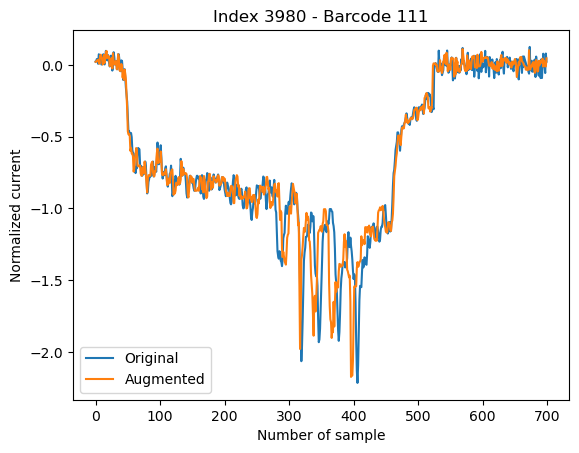

120


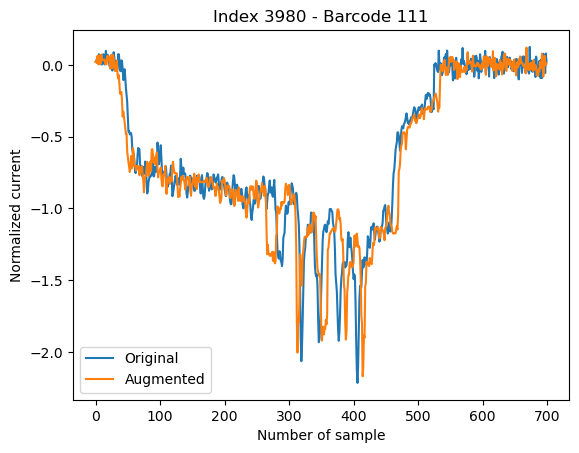

121


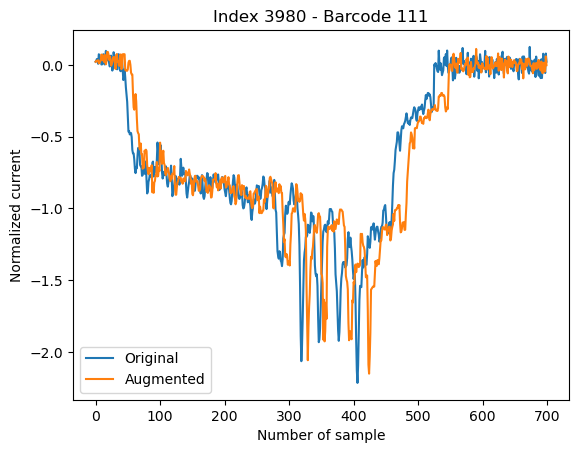

122


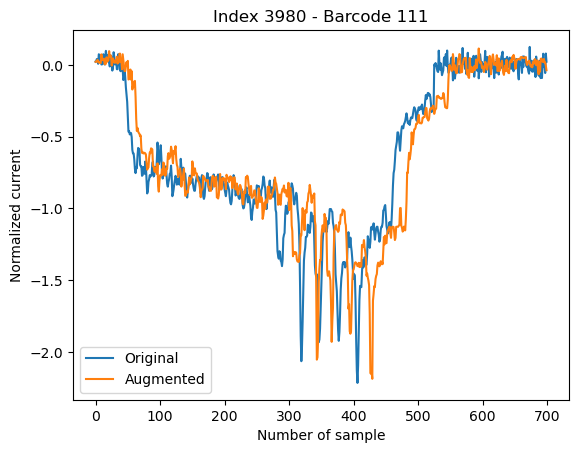

123


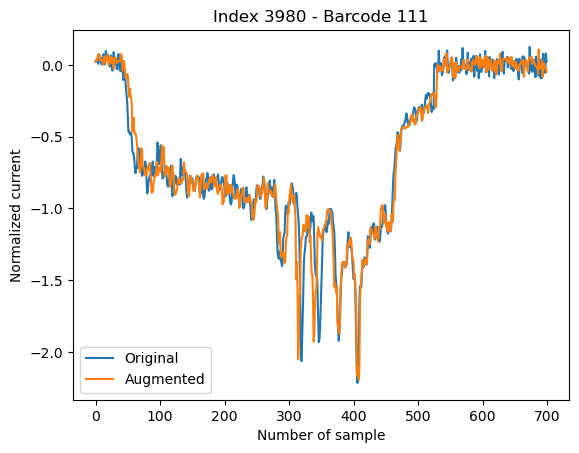

124


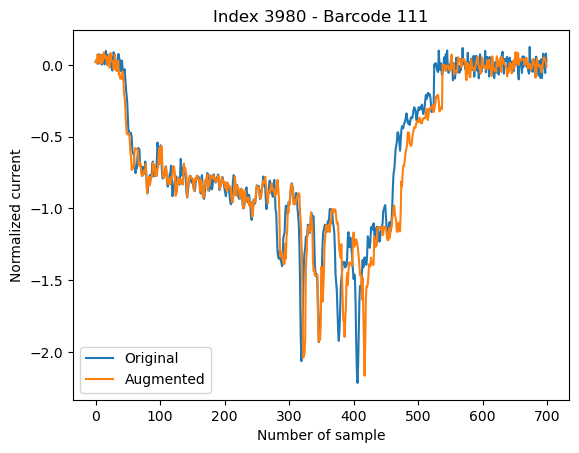

In [16]:
for Aug_idx_to_compare in range(100,125):
    print(Aug_idx_to_compare)
    plt.figure()
    plt.plot(trace_to_use_example,label="Original")
    plt.plot(out[Aug_idx_to_compare,:],label="Augmented")
    plt.xlabel("Number of sample")
    plt.ylabel("Normalized current")
    plt.title("Index "+str(id_sample) + " - Barcode "+barcode)
    plt.legend();
    plt.show()

Then we plot the augmentation of the picked example:

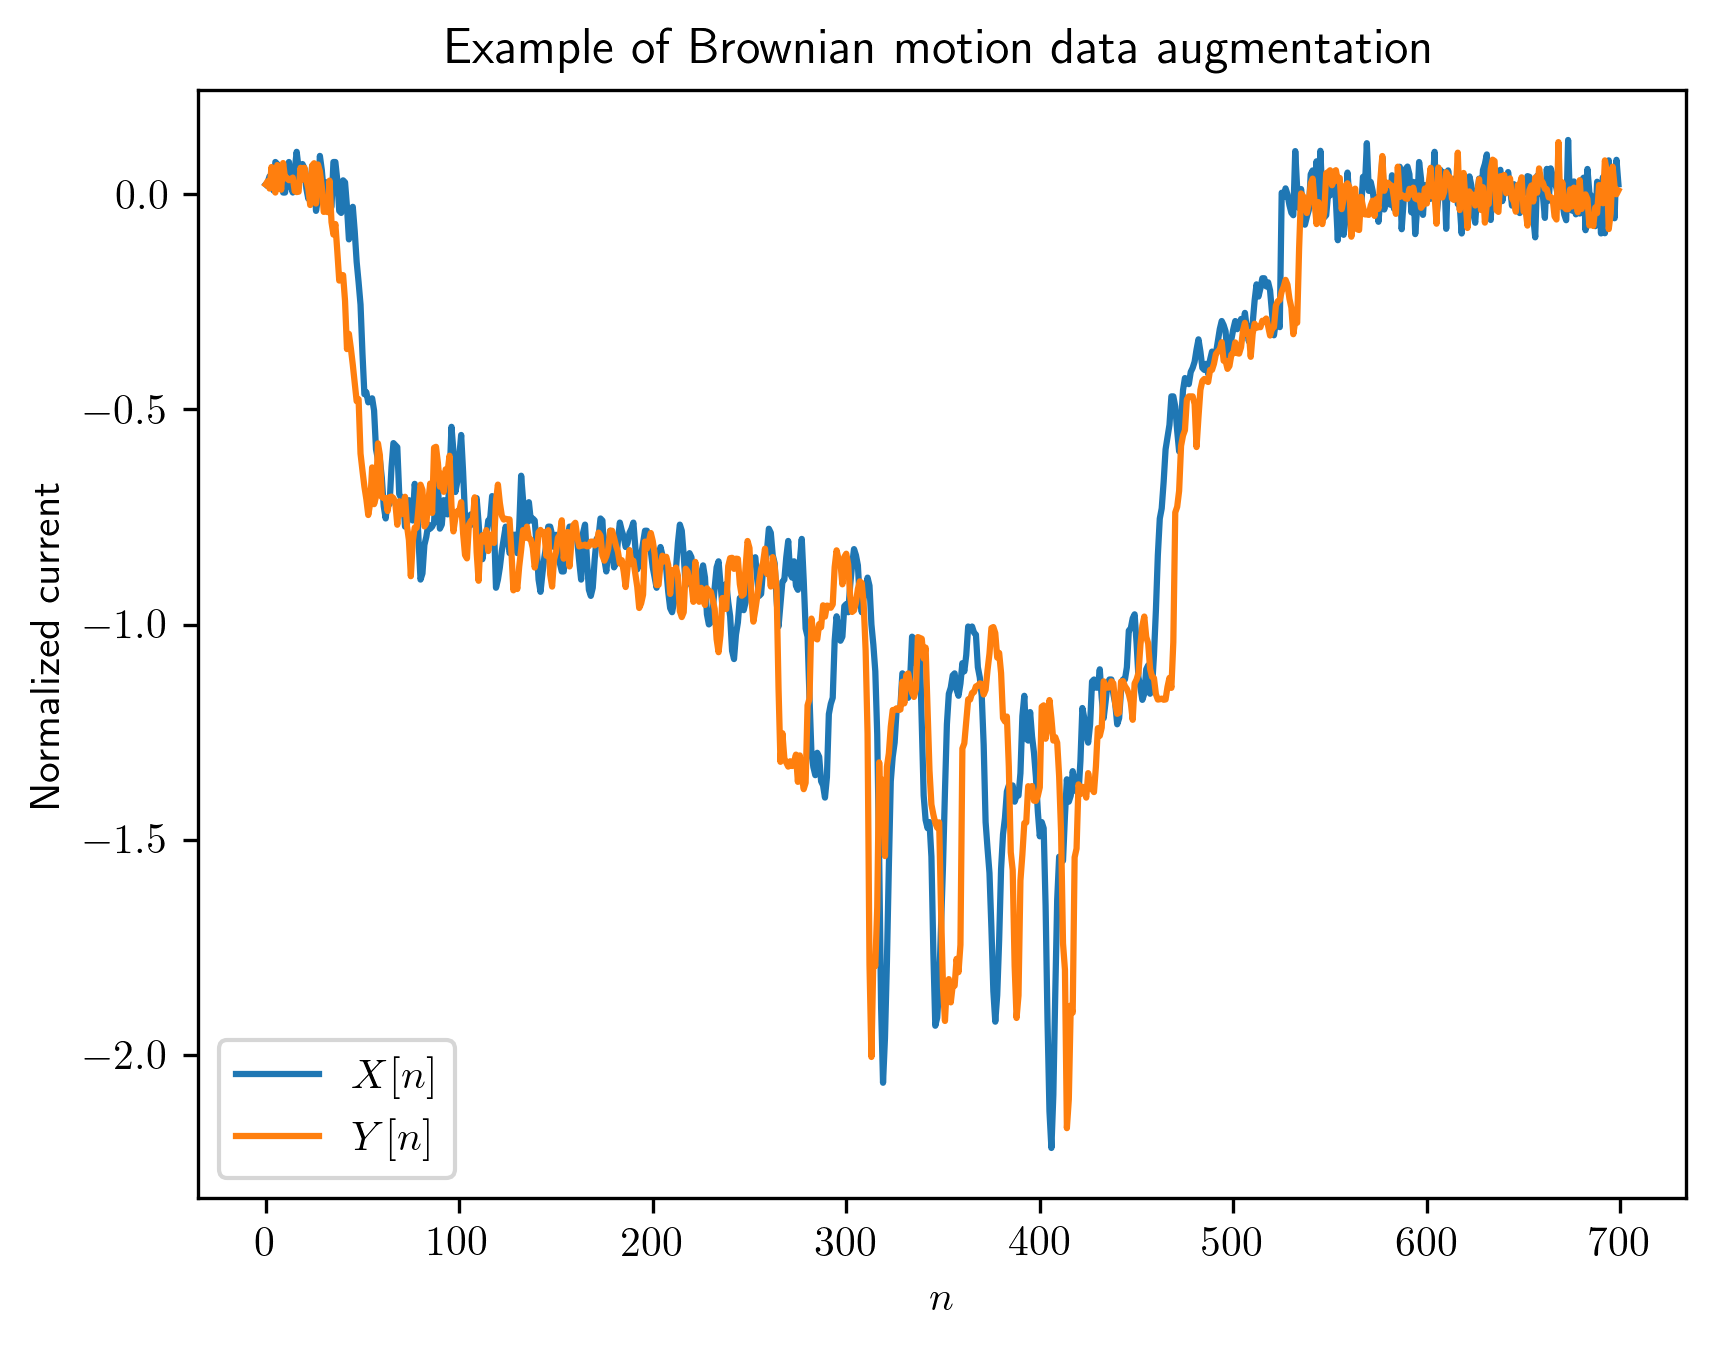

In [18]:
plt.rcParams.update({"text.usetex": True})
Aug_idx_to_compare=120
plt.figure(dpi=300)
plt.plot(trace_to_use_example,label=r'$X[n]$')
plt.plot(out[Aug_idx_to_compare,:],label=r'$Y[n]$')
plt.xlabel(r'$n$')
plt.ylabel("Normalized current")
plt.title("Example of Brownian motion data augmentation")
plt.legend();
plt.savefig("Fig1b.png") 

Finally, we plot the indices that generated that augmentation

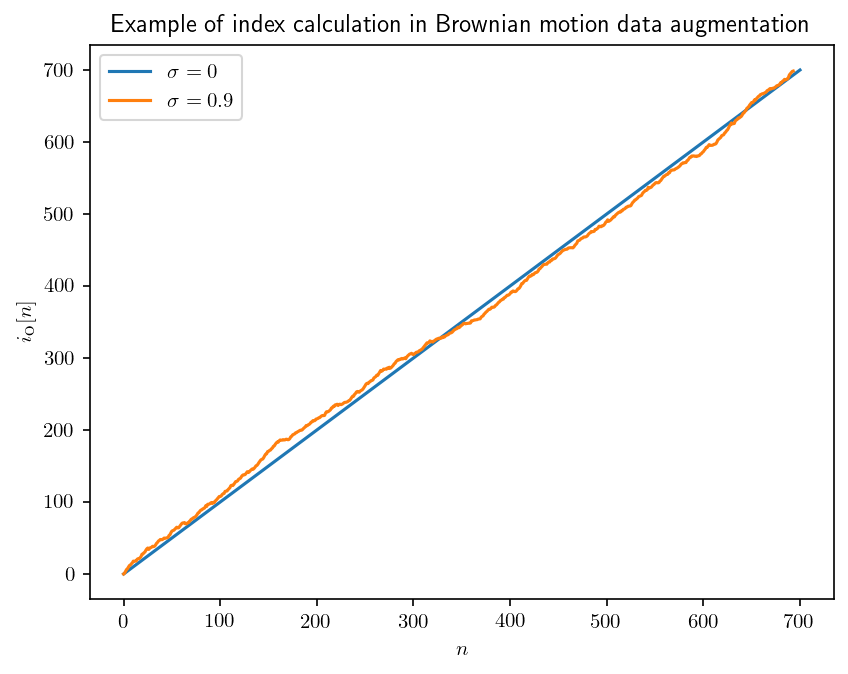

In [19]:
plt.figure(dpi=150)
plt.plot([0, 700], [0,700],label=r'$\sigma=0$')
browAugMap=[0]
for i in range(700):
    new_entry=1+browAugMap[i]+noise[Aug_idx_to_compare,i];
    if new_entry>700:
        break;
    else:
        browAugMap.append(new_entry)
plt.plot(browAugMap,label=r'$\sigma=0.9$')
plt.xlabel(r'$n$')
plt.ylabel(r'$i_{\textrm{o}}[n]$')
plt.legend();
plt.title("Example of index calculation in Brownian motion data augmentation")
plt.savefig("Fig1a.png") 

# Supporting Information

## Showing accuracy improvement


In [52]:
def get_accuracies_LR_match_str(str_to_match,lr_folder):
    N=0;
    all_accs=np.array([])
    for dirpath, dnames, fnames in os.walk(lr_folder):
        for f in fnames:
            if f.endswith(".csv") and (str_to_match in f):
                df=pd.read_csv(lr_folder+"/"+f)
                curr_accs=df.iloc[0:3,0].to_numpy()
                if all_accs.size==0:
                    all_accs=copy.deepcopy(curr_accs)
                else :
                    all_accs=np.vstack([all_accs, curr_accs])
                N=N+1;
    return all_accs

def get_accs_to_compare():
    all_accs_Brow=get_accuracies_LR_match_str("WBrowAug_090_N1_2048_N2_1024","../../results/CompareLRs/5E-04")
    all_accs_noBrow=get_accuracies_LR_match_str("Reproduction_N1_2048_N2_1024","../../results/CompareLRs/5E-04")
    return all_accs_noBrow,all_accs_Brow;

def check_accs(all_accs):
    N=np.shape(all_accs)[0]
    all_means=np.mean(all_accs,axis=0)*100
    all_maxs=np.percentile(all_accs, 90, axis=0)*100
    all_stds=np.std(all_accs,axis=0)*100/np.sqrt(N)
    train_mean=all_means[0];valid_mean=all_means[1];test_mean=all_means[2];
    train_std=all_stds[0];valid_std=all_stds[1];test_std=all_stds[2];
    test_max=all_maxs[2];
    print("Train Acc " + '{0:.2f}'.format(train_mean) + " +- " + '{0:.2f}'.format(train_std) +
         " Valid Acc " + '{0:.2f}'.format(valid_mean) + " +- " + '{0:.2f}'.format(valid_std)  +
         " Test Acc " + '{0:.2f}'.format(test_mean) + " +- " + '{0:.2f}'.format(test_std)  +
         " N = " + str(N))

In [66]:
all_accs_noBrow,all_accs_Brow=get_accs_to_compare()

### Estimator uncertainty

In [76]:
print("Checking accuracies of the model without brownian augmentation:")
check_accs(all_accs_noBrow)
print("Checking accuracies of the model with brownian augmentation:")
check_accs(all_accs_Brow)

Checking accuracies of the model without brownian augmentation:
Train Acc 99.14 +- 0.02 Valid Acc 96.54 +- 0.02 Test Acc 93.04 +- 0.11 N = 277
Checking accuracies of the model with brownian augmentation:
Train Acc 98.68 +- 0.01 Valid Acc 96.58 +- 0.02 Test Acc 93.43 +- 0.10 N = 349


In [77]:
diff=all_accs_Brow[:len(all_accs_noBrow),2]-all_accs_noBrow[:,2]; #Difference statistic (keeps less simulations, since there were more with the brownian one.)

In [80]:
m=np.mean(diff); #Mean of mean estimator
sigma=np.std(diff)/np.sqrt(len(diff)); #Std of mean estimator
prob_mu_hat_neg= stats.norm.cdf((0-m) / sigma);
p_mu_hat_pos=1-prob_mu_hat_neg;
print("The probability that the mean is higher than zero is approximately " + '{0:.5f}'.format(p_mu_hat_pos) + "%")

The probability that the mean is higher than zero is approximately 0.98748%


### p-value test

In [81]:
mu_t=0.5;std_t=0.5;
T_i=all_accs_Brow[:len(all_accs_noBrow),2]>all_accs_noBrow[:,2];
N=len(T_i);
avg_test=np.sum(T_i)/len(T_i)
std_final= std_t/np.sqrt(N);
z_score=(avg_test-mu_t)/std_final;
p_value=1-stats.norm.cdf(z_score); #P(u>\hat) |\mu_T,\sigma_T) Given the null hypothesis, what was the probability of the obtained results or worse!
print("The obtained p-value is: " + "{:.2f}".format(p_value*100) + "%. This value is significant to reject the null hypothesis and validate that the brownian augmentation has a better test accuracy!")

The obtained p-value is: 1.77%. This value is significant to reject the null hypothesis and validate that the brownian augmentation has a better test accuracy!


In [82]:
from math import comb
mu_t=0.5;std_t=0.5;
T_i=all_accs_Brow[:len(all_accs_noBrow),2]>all_accs_noBrow[:,2];
N=len(T_i);
s_e=sum(T_i);

prob_H0=0
for i in range(s_e,N):
    prob_H0=prob_H0+comb(N,i)* 0.5**N;
print(prob_H0)

0.020436263392851657


In [84]:
s_e/N

0.5631768953068592